# Concensus NMF running script

#### similar as described by cNMF team on github: https://github.com/dylkot/cNMF/blob/master/Tutorials/analyze_pbmc_example_data.ipynb

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
#from IPython.display import Imaged
import scanpy as sc
from cnmf import cNMF
import anndata as ad

np.random.seed(42)

In [2]:
dsp_count = pd.read_csv('../data/crs_count.csv')
dsp_count.shape

(533, 18676)

In [3]:
dsp_count

,CACNA1C,TMEM255B,GCSH,OR4F6,C9orf57,CSRNP1,HYLS1,UBE2QL1,ISLR,SERPINA5,...,LCE3A,PAEP,KIF1C,LAMTOR2,ARL4A,TIGD6,PRR18,OSBPL9,RFPL2,PSMA4
0,16.219535,4.054884,16.219535,4.054884,4.054884,8.109768,4.054884,12.164652,12.164652,4.054884,...,4.054884,4.054884,4.054884,8.109768,8.109768,4.054884,4.054884,8.109768,12.164652,12.164652
1,1.888462,1.888462,1.888462,1.888462,5.665385,3.776923,1.888462,3.776923,7.553846,1.888462,...,3.776923,1.888462,1.888462,3.776923,9.442308,1.888462,1.888462,1.888462,5.665385,1.888462
2,10.814663,12.359615,8.754727,11.329647,7.209776,23.174279,15.449519,9.269711,12.874599,11.844631,...,12.874599,7.209776,6.694792,20.599359,21.629327,11.329647,12.359615,16.994471,12.359615,20.599359
3,68.159626,66.536778,58.422537,66.536778,56.799689,73.028171,60.045385,64.913930,76.273868,50.308296,...,58.422537,64.913930,63.291082,68.159626,81.142412,60.045385,73.028171,81.142412,90.879502,73.028171
4,4.014635,8.029270,8.029270,8.029270,2.676423,2.676423,4.014635,2.676423,14.720328,5.352846,...,4.014635,6.691058,5.352846,16.058539,5.352846,6.691058,2.676423,10.705693,6.691058,4.014635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,1.349571,1.349571,1.349571,2.699142,1.349571,1.349571,1.349571,1.349571,1.349571,1.349571,...,1.349571,1.349571,1.349571,1.349571,1.349571,1.349571,1.349571,2.699142,1.349571,1.349571
529,6.439199,11.447465,10.731998,12.878398,8.585599,11.447465,5.008266,11.447465,7.870132,15.740264,...,12.162932,12.162932,14.309331,36.488795,12.162932,15.740264,10.731998,18.602131,10.731998,20.748530
530,2.688634,12.546959,5.377268,6.273480,5.377268,10.306431,8.514008,4.481057,14.339382,9.858325,...,6.721585,6.721585,6.721585,22.405284,7.617797,8.065902,5.825374,9.410219,5.825374,8.065902
531,2.132650,4.265299,4.265299,3.554416,0.710883,3.554416,2.843533,1.421766,4.265299,4.265299,...,1.421766,3.554416,4.265299,5.687065,4.976182,2.843533,6.397949,3.554416,1.421766,2.132650


In [4]:
dsp_count2 = dsp_count

# first remove the negative control probes
dsp_count2 = dsp_count2[dsp_count2.columns.drop(list(dsp_count2.filter(regex='Neg')))]

dsp_count2.shape

(533, 18676)

In [5]:
dsp = ad.AnnData(
    dsp_count2.to_numpy(), dtype=np.float32
)
dsp

save = '../data/crs_dsp.h5ad'
sc.write(save, dsp)

In [10]:
numiter=100 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=8000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '../data/cnmf_crs/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'cnmf_crs'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
K = ' '.join([str(i) for i in range(7,33,3)])

seed = 42 ## Specify a seed pseudorandom number generation for reproducibility

In [11]:
K

'7 10 13 16 19 22 25 28 31'

In [12]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [13]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
cnmf_obj.prepare(counts_fn=save, components=range(7,33,3),
                 n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

In [ ]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=5)

In [15]:
cnmf_obj.combine(skip_missing_files = True)

Combining factorizations for k=7.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_1.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_2.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_3.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_4.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_6.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_7.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_8.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_9.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_11.df.npz. Skipping.
Missing file: ../data/cnmf_crs/cnmf_crs/cnmf_tmp/cnmf_crs.spectra.k_7.iter_12.df.npz. Skipping.
Missing file: 

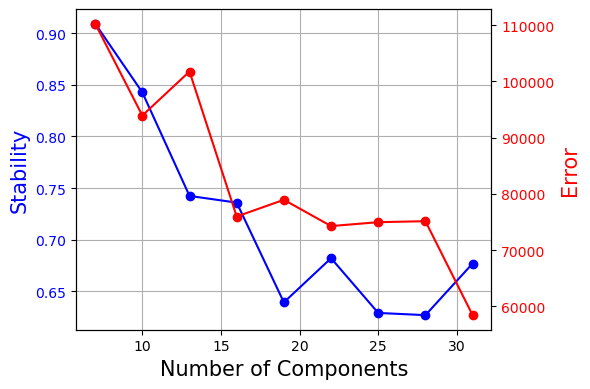

In [16]:
cnmf_obj.k_selection_plot(close_fig=False)

In [19]:
selected_K = 16
density_threshold = 2.00

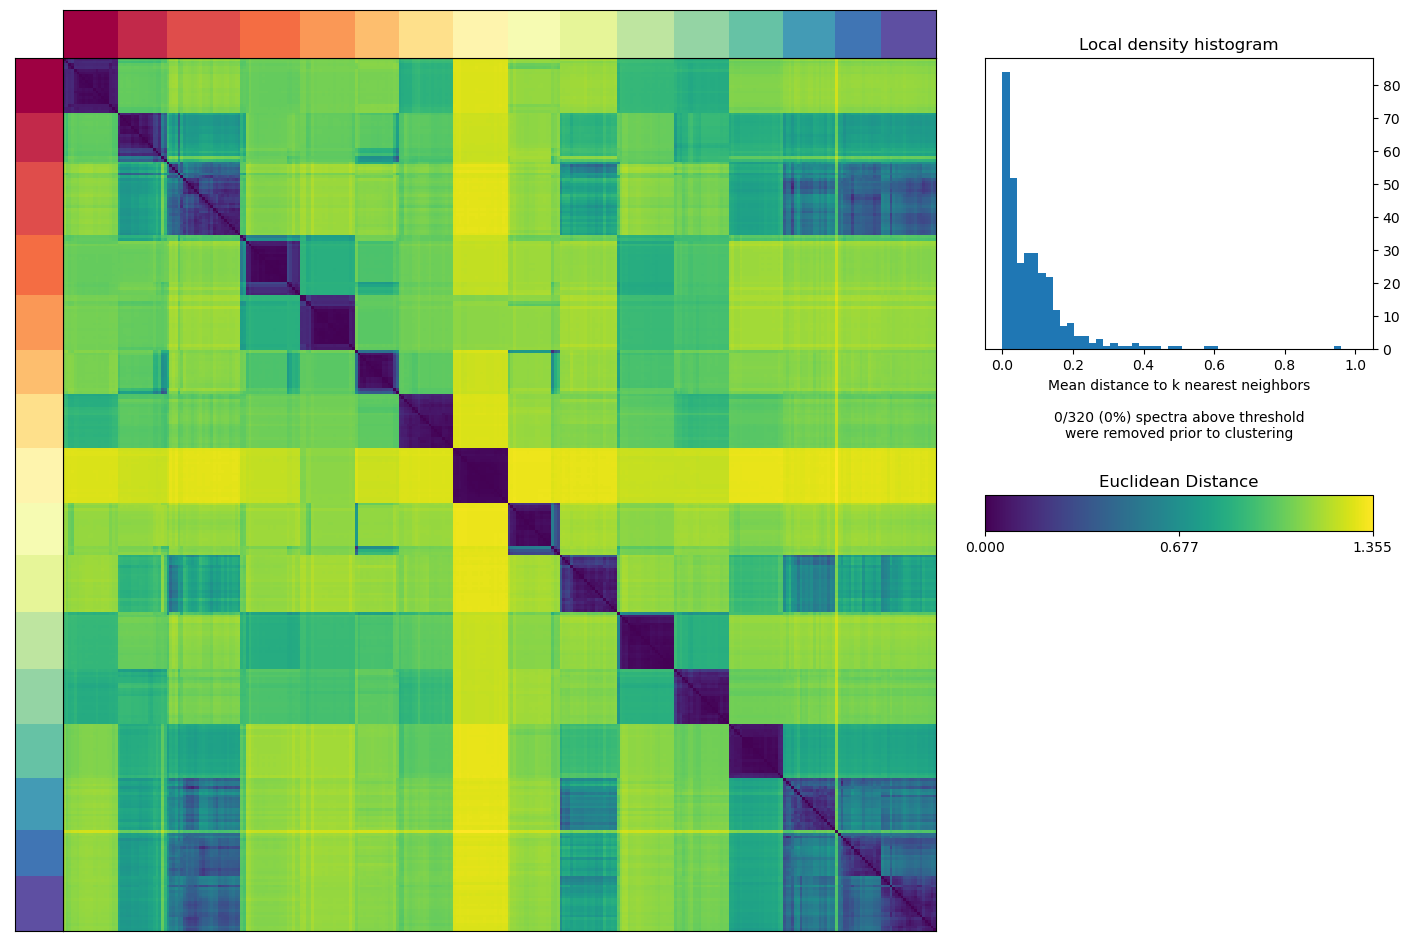

In [20]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)


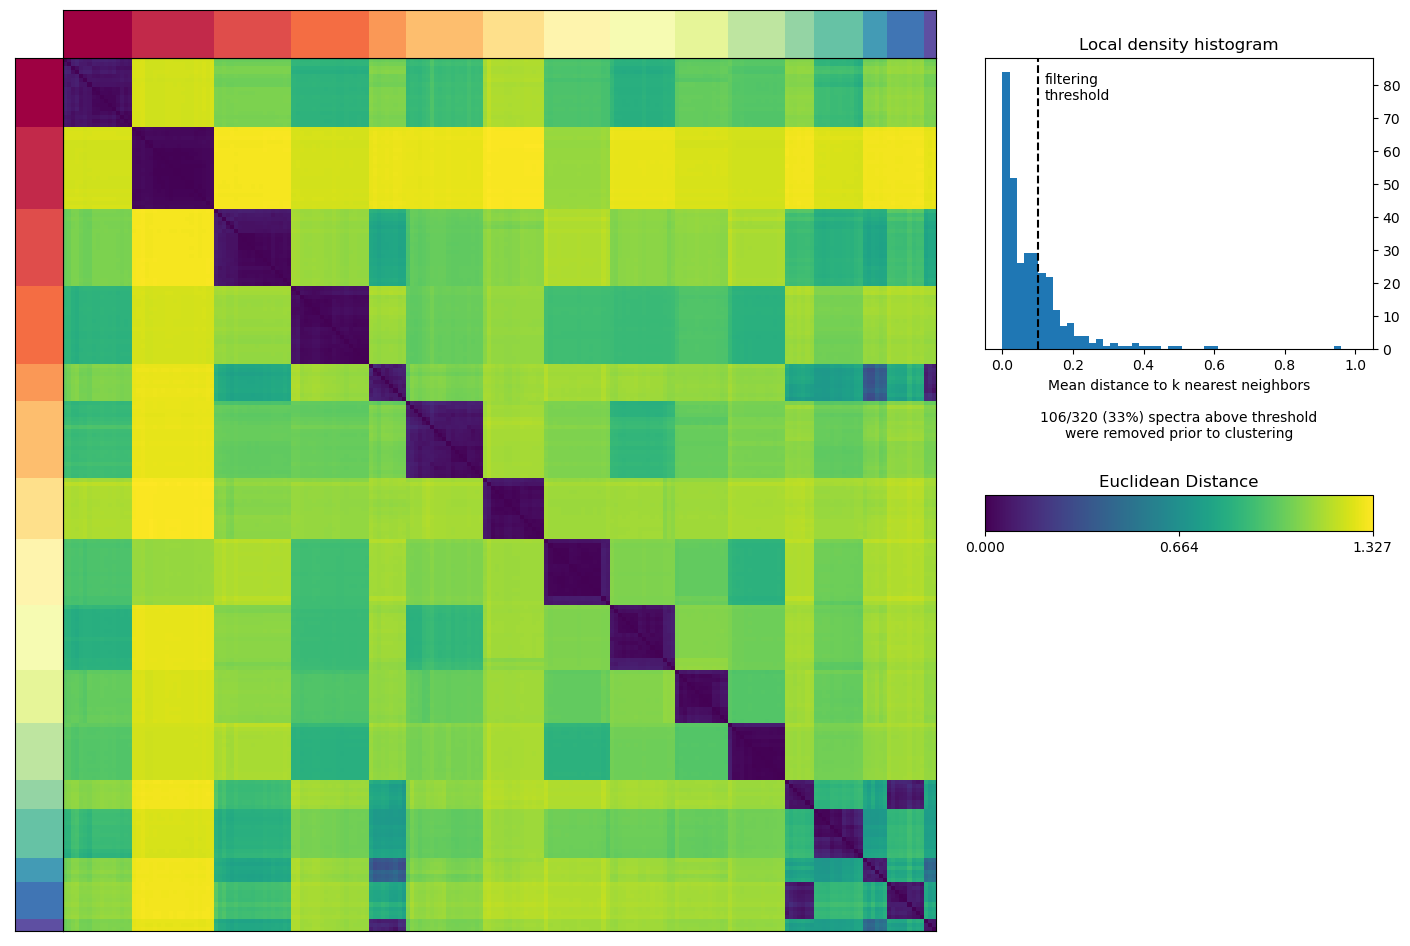

In [21]:
density_threshold = 0.10
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)


Load cnmf results??

In [22]:
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]

In [31]:
usage_norm.index = dsp_count.index
usage_norm

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,Usage_11,Usage_12,Usage_13,Usage_14,Usage_15,Usage_16
0,0.151318,0.279959,0.109492,0.000000,0.045568,0.056250,0.071707,0.026683,0.069055,0.022486,0.000000,0.086994,0.080489,0.000000,0.000000,0.000000
1,0.140076,0.272048,0.120624,0.000000,0.100779,0.102935,0.088531,0.028586,0.049263,0.020055,0.000000,0.070287,0.000000,0.000000,0.004938,0.001880
2,0.107380,0.119091,0.075248,0.054375,0.012486,0.000000,0.059909,0.000000,0.019812,0.327397,0.000000,0.067026,0.139443,0.000000,0.006056,0.011777
3,0.043528,0.430401,0.055637,0.009441,0.197135,0.028334,0.014624,0.030765,0.135888,0.008918,0.007564,0.003276,0.001288,0.029006,0.002063,0.002133
4,0.111964,0.109766,0.218396,0.049669,0.028124,0.231385,0.108824,0.070202,0.045735,0.024389,0.000000,0.000000,0.000000,0.001546,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,0.023347,0.376159,0.136000,0.018415,0.186072,0.066455,0.058748,0.000000,0.121687,0.001580,0.009571,0.001757,0.000207,0.000000,0.000000,0.000000
529,0.015502,0.168006,0.161914,0.201417,0.092682,0.006815,0.000000,0.000537,0.064012,0.044838,0.124701,0.019950,0.077486,0.017465,0.004675,0.000000
530,0.039702,0.051782,0.400979,0.000000,0.014890,0.102166,0.080859,0.101108,0.015080,0.080361,0.076819,0.018764,0.006732,0.000000,0.007718,0.003039
531,0.021943,0.167345,0.396150,0.003039,0.113025,0.168169,0.071390,0.000000,0.048687,0.000000,0.000000,0.000000,0.000000,0.006841,0.003412,0.000000


In [32]:
usage_norm.to_csv('../data/crs_cnmf16_usage.csv')

In [25]:
gep_scores.shape

(18676, 16)

In [26]:
topgenes.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,13815,4415,17525,17384,14330,16004,12400,6186,6362,1077,17762,10705,557,12540,1577,9374
1,8134,1286,17733,17815,3762,11386,18554,1206,10490,2707,11397,6514,3085,11328,2495,14330
2,3612,12540,9094,3416,9374,17880,14164,8463,11230,1030,13640,11820,14866,4415,4595,5706
3,16862,1008,862,6942,5115,16895,10656,16098,3701,17103,6835,12236,6356,18015,4433,16895
4,4817,11328,5320,3845,10726,2103,13673,11407,5107,9828,6854,10447,7130,5467,13733,5115
5,283,5644,16872,9007,16895,5978,17645,8558,13669,12194,17856,3665,18267,1286,17853,6290
6,2391,6024,5690,4260,5706,9845,7243,12311,11502,13071,14756,8017,12566,15585,6402,3762
7,4158,18015,11211,6644,4764,4417,1615,16996,9109,15040,12226,1085,9246,9766,7881,4764
8,12421,11785,7739,17424,6290,1586,16994,493,15640,14867,12618,7515,16813,6024,13863,10726
9,4396,5467,15254,1660,9191,7571,7127,8553,6073,2013,1007,14293,7578,5644,16905,9802


In [27]:
dd = {}
genelist = dsp_count2.columns.tolist()
for i in range(16):
    dd[i] = []
    #print(i)
    for j in range(100):
        #print(j)
        id = int(topgenes.iloc[j,i])
        gene = genelist[id]
        dd[i].append(gene)
df = pd.DataFrame.from_dict(dd)

In [28]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,C4orf46,SERTAD4,ZFP57,C6orf58,WAS,SFRP2,LAPTM5,IGKC,OR1S2,CAPS,STAT1,NR4A2,S100A2,SLC27A6,S100A8,CYTIP
1,XRCC2,PODXL,SUPT7L,DMBT1,CNGB1,IGF2,CD52,TXNDC5,GFPT2,FOXJ1,CFB,NR4A1,HSPB1,C18orf63,S100A7,WAS
2,PRAC1,SLC27A6,PTBP1,STATH,CYTIP,SPARC,LCP1,OR5K4,SPP2,RSPH1,TYMP,FOS,KRT5,SERTAD4,SPRR2A,PLEKHO1
3,ZNF776,LTB4R2,BASP1,ELAPOR1,WIPF1,THBS1,LTB,IGLL5,MYH3,CDHR3,TAP1,CEBPD,KRT17,KREMEN1,SPRR1A,THBS1
4,NPAP1L,C18orf63,MTCH2,TCN1,DRAXIN,CALD1,CORO1A,DERL3,GYS2,TPPP3,IDO1,JUNB,MYOF,ATAT1,KRT13,WIPF1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,KRTAP9-2,ZNF8,MUC19,TM9SF3,PIK3AP1,PDLIM7,H2AC19,TMED2,NSG2,CALM1,DDX60,MYADM,PKP1,DENND2B,FAM25A,IL10RA
96,ZNF117,CLEC5A,BNIP3L,PAM,ZNF804B,CNN2,H1-3,CASP10,RSPO3,DNAH12,SLFN5,H3-3B,TACSTD2,BCAM,LAD1,GAS6
97,NAT8B,PIGU,ARRDC1,NME2,FOXD4L1,C1QB,H4C12,C11orf80,PDCD7,CAPN13,ADAR,PIM1,TAGLN2,ARNTL2,NIBAN2,RGS1
98,GALNTL5,SPARCL1,ACSL4,RPL15,GOLGA6A,PLXDC2,HLA-DMB,CD38,RHOXF2,DHRS9,RSAD2,ITPKC,COX8A,TTC5,MBOAT2,HLA-DPB1


In [29]:
df.to_csv('../data/top100_genes_cnmf16.csv', index = False)